In [30]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import interpolate
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import os
import string
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import xarray as xr


sys.path.append('/home/sachin/miniconda3/envs/torch_env/') #sever
from esn_dts_openloop import ESN, Tikhonov

In [31]:
def open_omni():
    df = pd.read_csv('/home/sachin/Documents/NIPR/Research/Data/OMNI/omni_hro_5min_1999-10.csv')
    #df = pd.read_csv('/home/sachin/Documents/NIPR/Research/Data/OMNI/omni_hro2_5min_2004_2007.csv')
    
    df = df[df['BY_GSE'] < 100]
    df = df[df['BZ_GSE'] < 100]
    df = df[df['flow_speed'] < 1400]
    df = df[df['proton_density'] < 150]
    df = df[df['F10.7'] < 400]
    df = df[df['Kp'] < 100]
    df['Kp'] = df['Kp'] / 10
    df[['F10.7','flow_speed']] = df[['F10.7','flow_speed']].astype(int)
    
    df['Timestamp_1min_omni'] = pd.to_datetime(df['Timestamp_1min_omni'])
    
    #df = df[df['Timestamp_1min_omni'] == '1999-10-22 05:50:00']
    #df = df[df['Timestamp_1min_omni'].between('1999-10-22 03:00:00', '1999-10-22 08:30:00')]
    #df = df[df['Timestamp_1min_omni'].between('2004-01-01 00:00:00', '2004-12-31 23:59:59')]
    #df = df[df['Timestamp_1min_omni'].between('1999-10-22 03:00:00', '1999-10-22 08:30:00')]
    
    df = df.set_index('Timestamp_1min_omni')
    #df = df.resample('1h').mean(numeric_only=True)
    df = df.reset_index()

    return df

omni_data = open_omni()
omni_data

,Timestamp_1min_omni,BY_GSE,BZ_GSE,flow_speed,proton_density,AE_INDEX,AL_INDEX,AU_INDEX,Timestamp_1hr_omni,F10.7,Kp,tilt_angle
0,1999-10-01 00:00:00,1.84,0.66,485,4.17,178,-100,79,1999-10-01 00:00:00,121,2.3,-0.115365
1,1999-10-01 00:05:00,3.35,0.41,481,4.51,178,-107,71,1999-10-01 00:00:00,121,2.3,-0.119096
2,1999-10-01 00:10:00,3.26,0.45,480,4.63,178,-100,78,1999-10-01 00:00:00,121,2.3,-0.122795
3,1999-10-01 00:15:00,2.70,-1.26,480,4.81,169,-89,80,1999-10-01 00:00:00,121,2.3,-0.126461
4,1999-10-01 00:20:00,2.21,-1.06,475,4.71,227,-151,76,1999-10-01 00:00:00,121,2.3,-0.130093
...,...,...,...,...,...,...,...,...,...,...,...,...
8836,1999-10-31 23:35:00,-5.21,-2.83,441,9.98,269,-136,133,1999-10-31 23:00:00,158,3.0,-0.294976
8837,1999-10-31 23:40:00,-5.34,-3.97,443,10.59,276,-159,117,1999-10-31 23:00:00,158,3.0,-0.298838
8838,1999-10-31 23:45:00,-6.13,-3.75,439,10.79,347,-225,122,1999-10-31 23:00:00,158,3.0,-0.302679
8839,1999-10-31 23:50:00,-6.05,-1.36,440,10.92,336,-213,124,1999-10-31 23:00:00,158,3.0,-0.306496


In [32]:
def split_to_df(df):

    df = df.copy()

    #create grid of lat and lon
    lat = np.linspace(53.1, 89.7, 30) #30 intervals between 53.1° to 89.7°
    lon = np.linspace(1.6, 357.6, 80) #80 intervals between 1.6° to 357.6°

    lat_mesh, lon_mesh = np.meshgrid(lat, lon)
    lats = lat_mesh.flatten()
    lons = lon_mesh.flatten()

    #expand out df to lat and lon dims. Aka repeat values 
    expanded_df = pd.DataFrame({'lat': lats.repeat(len(df)), 
                                'lon': lons.repeat(len(df)),
                                'BY_GSE': np.tile(df['BY_GSE'], len(lat)*len(lon)),
                                'BZ_GSE': np.tile(df['BZ_GSE'], len(lat)*len(lon)),
                                'flow_speed': np.tile(df['flow_speed'], len(lat)*len(lon)),
                                'proton_density': np.tile(df['proton_density'], len(lat)*len(lon)),
                                'tilt_angle': np.tile(df['tilt_angle'], len(lat)*len(lon)),
                                'dt': np.tile(df['Timestamp_1min_omni'], len(lat)*len(lon)),
                                'F10.7': np.tile(df['F10.7'], len(lat)*len(lon)),
                                'Kp': np.tile(df['Kp'], len(lat)*len(lon)),
                                'AE_INDEX': np.tile(df['AE_INDEX'], len(lat)*len(lon)),
                                'AL_INDEX': np.tile(df['AL_INDEX'], len(lat)*len(lon)),
                                'AU_INDEX': np.tile(df['AU_INDEX'], len(lat)*len(lon))
                                })

    expanded_df['mlt'] = np.mod(expanded_df['lon'] + 12, 360) / 15


    df_esn = expanded_df.copy()
    df_esn = df_esn[['dt','lat','lon','BY_GSE','BZ_GSE','flow_speed','proton_density','tilt_angle']]
    
    return df_esn

df_esn = split_to_df(omni_data)
df_esn

,dt,lat,lon,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle
0,1999-10-01 00:00:00,53.1,1.6,1.84,0.66,485,4.17,-0.115365
1,1999-10-01 00:05:00,53.1,1.6,3.35,0.41,481,4.51,-0.119096
2,1999-10-01 00:10:00,53.1,1.6,3.26,0.45,480,4.63,-0.122795
3,1999-10-01 00:15:00,53.1,1.6,2.70,-1.26,480,4.81,-0.126461
4,1999-10-01 00:20:00,53.1,1.6,2.21,-1.06,475,4.71,-0.130093
...,...,...,...,...,...,...,...,...
21218395,1999-10-31 23:35:00,89.7,357.6,-5.21,-2.83,441,9.98,-0.294976
21218396,1999-10-31 23:40:00,89.7,357.6,-5.34,-3.97,443,10.59,-0.298838
21218397,1999-10-31 23:45:00,89.7,357.6,-6.13,-3.75,439,10.79,-0.302679
21218398,1999-10-31 23:50:00,89.7,357.6,-6.05,-1.36,440,10.92,-0.306496


In [33]:
def load_esn(df):

    df = df.copy()
    df['dt'] = pd.to_datetime(df['dt'])
    df = df.set_index(['dt','lat','lon'])
    ds = df.to_xarray()
    
    ds['BY_GSE'] = ds['BY_GSE'].mean(dim=['lat', 'lon'])
    ds['BZ_GSE'] = ds['BZ_GSE'].mean(dim=['lat', 'lon'])
    ds['flow_speed'] = ds['flow_speed'].mean(dim=['lat', 'lon'])
    ds['proton_density'] = ds['proton_density'].mean(dim=['lat', 'lon'])
    ds['tilt_angle'] = ds['tilt_angle'].mean(dim=['lat', 'lon'])

    def load_model_pca(parameter, id):
        
        with open(f'/home/sachin/Documents/NIPR/Research/Data/ESN/models/SMRAI2_{parameter}_ID{id}.pkl', 'rb') as f:
            model = pickle.load(f)

        
        pca_reload = pickle.load(open(f'/home/sachin/Documents/NIPR/Research/Data/ESN/models/ESN_{parameter}_pca_ID{id}.pkl','rb'))

        return model, pca_reload
    
    pot_model, pot_pca = load_model_pca('potential', 25)
    x_model, x_pca = load_model_pca('x-cond', 5)
    y_model, y_pca = load_model_pca('y-cond', 5)
    xy_model, xy_pca = load_model_pca('xy-cond', 5)
   # fac_model, fac_pca = load_model_pca('fac', 5)

    def make_predictions(ds, model, pca):
        ds = ds.copy()
        prediction_arr = ds.to_array().values.T
        prediction = model.predict(prediction_arr)

        prediction_original = pca.inverse_transform(prediction)
        prediction_original = prediction_original.reshape(-1, 30,80)

        return prediction_original

    prediction_potential = make_predictions(ds, pot_model, pot_pca)
    prediction_x = make_predictions(ds, x_model, x_pca)
    prediction_y = make_predictions(ds, y_model, y_pca)
    prediction_xy = make_predictions(ds, xy_model, xy_pca)
    #prediction_fac = make_predictions(ds, fac_model, fac_pca)

    ds['esn_pot'] = (('dt','lat','lon'), prediction_potential)
    ds['esn_x'] = (('dt','lat','lon'), prediction_x)
    ds['esn_y'] = (('dt','lat','lon'), prediction_y)
    ds['esn_xy'] = (('dt','lat','lon'), prediction_xy)
    #ds['esn_fac'] = (('dt','lat','lon'), prediction_fac)

    #df = ds.to_dataframe()
    #df = df.reset_index()
    #df = df[df['lat'].between(60, 70)]

    return ds

df_esn = load_esn(df_esn)
df_esn

<xarray.Dataset> Size: 679MB
Dimensions:         (dt: 8841, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 71kB 1999-10-01 ... 1999-10-31T23:55:00
  * lat             (lat) float64 240B 53.1 54.36 55.62 ... 87.18 88.44 89.7
  * lon             (lon) float64 640B 1.6 6.106 10.61 ... 348.6 353.1 357.6
Data variables:
    BY_GSE          (dt) float64 71kB 1.84 3.35 3.26 2.7 ... -6.13 -6.05 -5.69
    BZ_GSE          (dt) float64 71kB 0.66 0.41 0.45 -1.26 ... -3.75 -1.36 -2.22
    flow_speed      (dt) float64 71kB 485.0 481.0 480.0 ... 439.0 440.0 443.0
    proton_density  (dt) float64 71kB 4.17 4.51 4.63 4.81 ... 10.79 10.92 10.68
    tilt_angle      (dt) float64 71kB -0.1154 -0.1191 ... -0.3065 -0.3103
    esn_pot         (dt, lat, lon) float64 170MB 2.312 1.988 ... -20.1 -20.11
    esn_x           (dt, lat, lon) float64 170MB 1.844 1.844 ... 1.637 1.637
    esn_y           (dt, lat, lon) float64 170MB 1.624 1.624 ... 1.637 1.637
    esn_xy          (dt, lat, lon) float64 170MB 1.516 1.516 ... 1.69 1.689

In [34]:
def calculate_E(ds):
    ds = ds.copy()

    def calculate_distance(lat1, lon1, lat2, lon2):
        
        radius = 6371.008 * 1000 #km to m

        dlat = np.radians(lat2 - lat1)
        dlon = np.radians(lon2 - lon1)
        delta_x = dlat * radius #111.32 km per degree
        delta_y = dlon * radius * np.cos(np.radians(lat1)) 

        area = delta_x * delta_y
        #avg_lat = np.radians(lat1 + lat2) / 2
        #area = radius**2 *  dlat * dlon * np.cos(avg_lat)
        
        return delta_x, delta_y, area

    def calculate_delta(mlat, mlt):
        #loop through lat and lon and calculate distance between each point
        areas = np.zeros((len(mlat) - 1, len(mlt) - 1))
        delta_x = np.zeros((len(mlat) - 1, len(mlt) - 1))
        delta_y = np.zeros((len(mlat) - 1, len(mlt) - 1))
        for i in range(len(mlat) - 1):
            for j in range(len(mlt) - 1):
                lat1, lat2 = mlat[i], mlat[i + 1]
                lon1, lon2 = mlt[j], mlt[j + 1]

                dx, dy, area = calculate_distance(lat1, lon1, lat2, lon2)
                #area = dx * dy
                delta_x[i, j] = dx
                delta_y[i, j] = dy
                areas[i, j] = area

        x = np.arange(areas.shape[1])
        y = np.arange(areas.shape[0])
        f = interpolate.interp2d(x, y, areas, kind='linear')
        xnew = np.arange(0, areas.shape[1], areas.shape[1]/(areas.shape[1]+1))
        ynew = np.arange(0, areas.shape[0], areas.shape[0]/(areas.shape[0]+1))
        areas = f(xnew, ynew)

        return delta_x, delta_y, areas
    
    #loop through each timestep and calculate the gradient based on potential, with spacings of dx and dy
    data_array = []
    for dt in ds['dt'].values:
        ds_dt = ds.sel(dt=dt)

        lat = ds_dt['lat'].values
        lon = ds_dt['lon'].values

        delta_x, delta_y, areas = calculate_delta(lat, lon)
        #delta_x, delta_y = delta_x * 1000, delta_y * 1000 #km to m
        #delta_y = np.flipud(delta_y)
        
        potential = ds_dt['esn_pot'].values * 1000  #kV to V

        #add 0 to end of delta_x dim 0
        delta_x = np.append(delta_x, np.ones((1, delta_x.shape[1])), axis=0)
        delta_y = np.append(delta_y, np.ones((delta_y.shape[0], 1)), axis=1)
        #area = delta_x * delta_y

        grad_x = np.zeros((potential.shape[0], potential.shape[1] - 1), dtype=np.float64)
        grad_y = np.zeros((potential.shape[0] - 1, potential.shape[1]), dtype=np.float64)

        # Calculate lon with dynamic spacing
        for i in range(potential.shape[0]):
            grad_x[i, :] = (potential[i, 1:] - potential[i, :-1]) / delta_x[i, :]

        # Calculate lat with dynamic spacing
        for j in range(potential.shape[1]):
            grad_y[:, j] = (potential[1:, j] - potential[:-1, j]) / delta_y[:, j]

        # Initialize full gradients to match the original array shape
        grad_x_full = np.zeros_like(potential, dtype=np.float64)
        grad_y_full = np.zeros_like(potential, dtype=np.float64)

        grad_x_full[:, :-1] = grad_x
        grad_x_full[:, -1] = (potential[:, -1] - potential[:, -2]) / delta_x[:, -1]  # Simple forward difference

        grad_y_full[:-1, :] = grad_y
        grad_y_full[-1, :] = (potential[-1, :] - potential[-2, :]) / delta_y[-1, :]  #
        
        Ex = -grad_x_full
        Ey = -grad_y_full

        ds_dt['Ex'] = (('lat','lon'), Ex)  
        ds_dt['Ey'] = (('lat','lon'), Ey)
        ds_dt['area'] = (('lat','lon'), areas)

        data_array.append(ds_dt)

    ds = xr.concat(data_array, dim='dt')
    ds = ds.sel(lat=slice(50, 89), lon=slice(0, 357))

    return ds

ds_E = calculate_E(df_esn)
ds_E

/tmp/ipykernel_59075/3183291674.py:37: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f = interpolate.interp2d(x, y, areas, kind='linear')
/tmp/ipykernel_59075/3183291674.py:40: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator

<xarray.Dataset> Size: 1GB
Dimensions:         (dt: 8841, lat: 29, lon: 79)
Coordinates:
  * dt              (dt) datetime64[ns] 71kB 1999-10-01 ... 1999-10-31T23:55:00
  * lat             (lat) float64 232B 53.1 54.36 55.62 ... 85.91 87.18 88.44
  * lon             (lon) float64 632B 1.6 6.106 10.61 ... 344.1 348.6 353.1
Data variables:
    BY_GSE          (dt) float64 71kB 1.84 3.35 3.26 2.7 ... -6.13 -6.05 -5.69
    BZ_GSE          (dt) float64 71kB 0.66 0.41 0.45 -1.26 ... -3.75 -1.36 -2.22
    flow_speed      (dt) float64 71kB 485.0 481.0 480.0 ... 439.0 440.0 443.0
    proton_density  (dt) float64 71kB 4.17 4.51 4.63 4.81 ... 10.79 10.92 10.68
    tilt_angle      (dt) float64 71kB -0.1154 -0.1191 ... -0.3065 -0.3103
    esn_pot         (dt, lat, lon) float64 162MB 2.312 1.988 ... -19.41 -19.51
    esn_x           (dt, lat, lon) float64 162MB 1.844 1.844 ... 1.633 1.631
    esn_y           (dt, lat, lon) float64 162MB 1.624 1.624 ... 1.632 1.63
    esn_xy          (dt, lat, lon) float64 162MB 1.516 1.516 ... 1.712 1.707
    Ex              (dt, lat, lon) float64 162MB 0.002313 0.00239 ... 0.0006911
    Ey              (dt, lat, lon) float64 162MB -0.0003008 ... 0.04316
    area            (dt, lat, lon) float64 162MB 4.222e+10 ... 3.362e+09

In [35]:
ds_E['Jhx'] = (-ds_E['esn_xy'] * ds_E['Ex']) * 1000  #east-west 
ds_E['Jhy'] = (ds_E['esn_xy'] * ds_E['Ey']) *  1000 #north-south
ds_E

<xarray.Dataset> Size: 1GB
Dimensions:         (dt: 8841, lat: 29, lon: 79)
Coordinates:
  * dt              (dt) datetime64[ns] 71kB 1999-10-01 ... 1999-10-31T23:55:00
  * lat             (lat) float64 232B 53.1 54.36 55.62 ... 85.91 87.18 88.44
  * lon             (lon) float64 632B 1.6 6.106 10.61 ... 344.1 348.6 353.1
Data variables: (12/14)
    BY_GSE          (dt) float64 71kB 1.84 3.35 3.26 2.7 ... -6.13 -6.05 -5.69
    BZ_GSE          (dt) float64 71kB 0.66 0.41 0.45 -1.26 ... -3.75 -1.36 -2.22
    flow_speed      (dt) float64 71kB 485.0 481.0 480.0 ... 439.0 440.0 443.0
    proton_density  (dt) float64 71kB 4.17 4.51 4.63 4.81 ... 10.79 10.92 10.68
    tilt_angle      (dt) float64 71kB -0.1154 -0.1191 ... -0.3065 -0.3103
    esn_pot         (dt, lat, lon) float64 162MB 2.312 1.988 ... -19.41 -19.51
    ...              ...
    esn_xy          (dt, lat, lon) float64 162MB 1.516 1.516 ... 1.712 1.707
    Ex              (dt, lat, lon) float64 162MB 0.002313 0.00239 ... 0.0006911
    Ey              (dt, lat, lon) float64 162MB -0.0003008 ... 0.04316
    area            (dt, lat, lon) float64 162MB 4.222e+10 ... 3.362e+09
    Jhx             (dt, lat, lon) float64 162MB -3.507 -3.625 ... -1.128 -1.18
    Jhy             (dt, lat, lon) float64 162MB -0.4561 -0.3267 ... 83.39 73.69

In [36]:
#interpolate ds_E over 1 daily
#ds_E = ds_E.resample(dt='1D').mean()
df_E = ds_E.to_dataframe()
df_E = df_E.reset_index()
df_E

,dt,lat,lon,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,esn_pot,esn_x,esn_y,esn_xy,Ex,Ey,area,Jhx,Jhy
0,1999-10-01 00:00:00,53.100000,1.600000,1.84,0.66,485.0,4.17,-0.115365,2.312141,1.844319,1.624137,1.516323,0.002313,-0.000301,4.222137e+10,-3.506944,-0.456124
1,1999-10-01 00:00:00,53.100000,6.106329,1.84,0.66,485.0,4.17,-0.115365,1.987573,1.844318,1.624140,1.516316,0.002390,-0.000215,4.222137e+10,-3.624720,-0.326716
2,1999-10-01 00:00:00,53.100000,10.612658,1.84,0.66,485.0,4.17,-0.115365,1.652104,1.844318,1.624139,1.516316,0.002446,-0.000132,4.222137e+10,-3.708966,-0.199428
3,1999-10-01 00:00:00,53.100000,15.118987,1.84,0.66,485.0,4.17,-0.115365,1.308837,1.844318,1.624139,1.516317,0.002479,-0.000050,4.222137e+10,-3.758644,-0.075151
4,1999-10-01 00:00:00,53.100000,19.625316,1.84,0.66,485.0,4.17,-0.115365,0.960973,1.844319,1.624139,1.516317,0.002488,0.000030,4.222137e+10,-3.772697,0.045137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20254726,1999-10-31 23:55:00,88.437931,335.068354,-5.69,-2.22,443.0,10.68,-0.310287,-19.159150,1.639056,1.638282,1.729493,0.000575,0.064181,3.361505e+09,-0.994740,111.000222
20254727,1999-10-31 23:55:00,88.437931,339.574684,-5.69,-2.22,443.0,10.68,-0.310287,-19.239866,1.636737,1.635969,1.723206,0.000610,0.059272,3.361505e+09,-1.050342,102.137890
20254728,1999-10-31 23:55:00,88.437931,344.081013,-5.69,-2.22,443.0,10.68,-0.310287,-19.325404,1.634689,1.633901,1.717492,0.000638,0.054092,3.361505e+09,-1.095564,92.903170
20254729,1999-10-31 23:55:00,88.437931,348.587342,-5.69,-2.22,443.0,10.68,-0.310287,-19.414922,1.632863,1.632075,1.712300,0.000659,0.048698,3.361505e+09,-1.127897,83.385327


In [37]:
df_E.groupby('dt')['Jhy'].max().reset_index()

,dt,Jhy
0,1999-10-01 00:00:00,159.421424
1,1999-10-01 00:05:00,128.929526
2,1999-10-01 00:10:00,121.541609
3,1999-10-01 00:15:00,153.398193
4,1999-10-01 00:20:00,167.327414
...,...,...
8836,1999-10-31 23:35:00,239.686894
8837,1999-10-31 23:40:00,224.804671
8838,1999-10-31 23:45:00,238.800940
8839,1999-10-31 23:50:00,208.777689


In [38]:
df_JHy_esn_max = df_E.groupby('dt')['Jhy'].max().reset_index()
df_JHy_esn_max.columns = ['dt','AU']

df_JHy_esn_min = df_E.groupby('dt')['Jhy'].min().reset_index()
df_JHy_esn_min.columns = ['dt','AL']

df_ae = pd.merge(df_JHy_esn_max, df_JHy_esn_min, on='dt')

df_ae['AE'] = df_ae['AU'] - df_ae['AL']
df_ae = df_ae[df_ae['AE'] < 4000]

omni_data['dt'] = pd.to_datetime(omni_data['Timestamp_1min_omni'])
merge_df = pd.merge(df_ae, omni_data, on='dt')
merge_df.head()

,dt,AU,AL,AE,Timestamp_1min_omni,BY_GSE,BZ_GSE,flow_speed,proton_density,AE_INDEX,AL_INDEX,AU_INDEX,Timestamp_1hr_omni,F10.7,Kp,tilt_angle
0,1999-10-01 00:00:00,159.421424,-203.924672,363.346096,1999-10-01 00:00:00,1.84,0.66,485,4.17,178,-100,79,1999-10-01 00:00:00,121,2.3,-0.115365
1,1999-10-01 00:05:00,128.929526,-176.490918,305.420444,1999-10-01 00:05:00,3.35,0.41,481,4.51,178,-107,71,1999-10-01 00:00:00,121,2.3,-0.119096
2,1999-10-01 00:10:00,121.541609,-172.515288,294.056897,1999-10-01 00:10:00,3.26,0.45,480,4.63,178,-100,78,1999-10-01 00:00:00,121,2.3,-0.122795
3,1999-10-01 00:15:00,153.398193,-188.516900,341.915093,1999-10-01 00:15:00,2.70,-1.26,480,4.81,169,-89,80,1999-10-01 00:00:00,121,2.3,-0.126461
4,1999-10-01 00:20:00,167.327414,-196.737654,364.065068,1999-10-01 00:20:00,2.21,-1.06,475,4.71,227,-151,76,1999-10-01 00:00:00,121,2.3,-0.130093


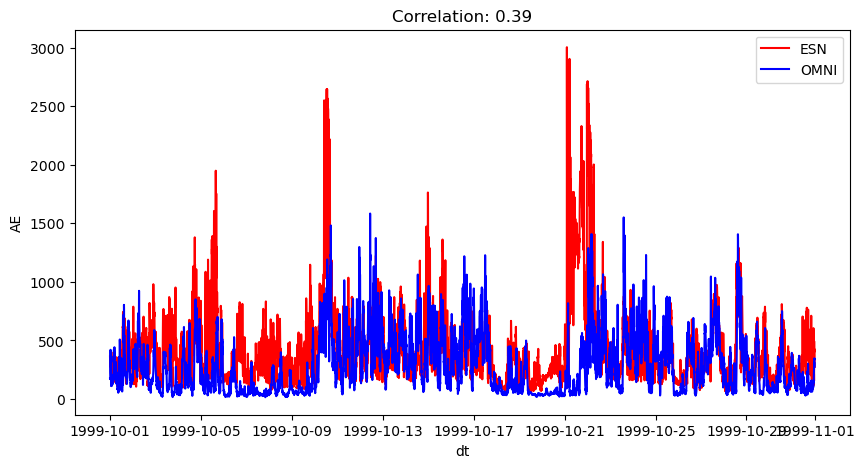

In [39]:
fig, ax = plt.subplots(figsize=(10,5))
R = np.corrcoef(merge_df['AE'], merge_df['AE_INDEX'])[0,1]
plt.title(f'Correlation: {R:.2f}')
sns.lineplot(data=merge_df, x='dt', y='AE', color='red', label='ESN', ax=ax, legend=False)
sns.lineplot(data=merge_df, x='Timestamp_1min_omni', y='AE_INDEX', color='blue', label='OMNI', ax=ax)
plt.legend()

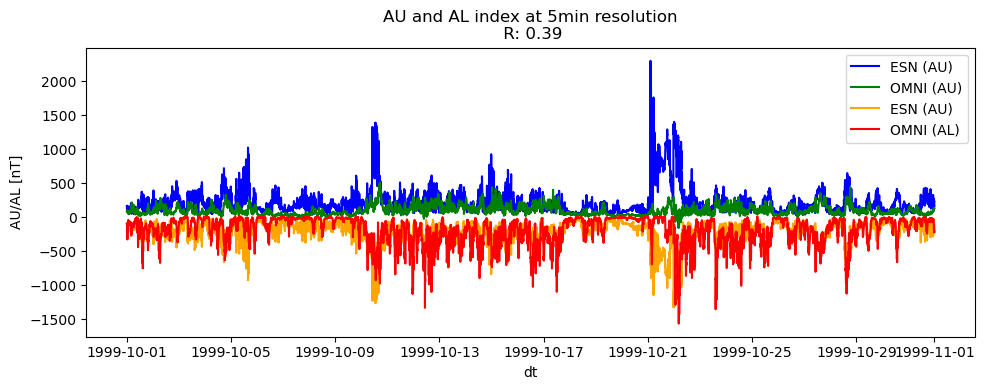

In [40]:
fig, ax = plt.subplots(figsize=(10,4))
R = np.corrcoef(merge_df['AE'], merge_df['AE_INDEX'])[0,1]
sns.lineplot(data=merge_df, x='dt', y='AU', color='blue', label='ESN (AU)', legend=False)
sns.lineplot(data=merge_df, x='Timestamp_1min_omni', y='AU_INDEX', color='green', label='OMNI (AU)')
sns.lineplot(data=merge_df, x='dt', y='AL', color='orange', label='ESN (AU)', legend=False)
sns.lineplot(data=merge_df, x='Timestamp_1min_omni', y='AL_INDEX', color='red', label='OMNI (AL)')
plt.ylabel('AU/AL [nT]')
plt.title(f'AU and AL index at 5min resolution\n R: {R:.2f}')
plt.tight_layout()
#plt.savefig('ESN_AU-AL_5min.png', dpi=300)

In [41]:
#ds_E['JPx'] = ds_E['esn_x'] * ds_E['Ex']
#ss_E['JPy'] = ds_E['esn_y'] * ds_E['Ey']
ds_E['Qjx'] = ((ds_E['esn_x']) * (ds_E['Ex'])**2) *1e3
ds_E['Qjy'] = ((ds_E['esn_y']) * (ds_E['Ey'])**2) *1e3
ds_E

<xarray.Dataset> Size: 2GB
Dimensions:         (dt: 8841, lat: 29, lon: 79)
Coordinates:
  * dt              (dt) datetime64[ns] 71kB 1999-10-01 ... 1999-10-31T23:55:00
  * lat             (lat) float64 232B 53.1 54.36 55.62 ... 85.91 87.18 88.44
  * lon             (lon) float64 632B 1.6 6.106 10.61 ... 344.1 348.6 353.1
Data variables: (12/16)
    BY_GSE          (dt) float64 71kB 1.84 3.35 3.26 2.7 ... -6.13 -6.05 -5.69
    BZ_GSE          (dt) float64 71kB 0.66 0.41 0.45 -1.26 ... -3.75 -1.36 -2.22
    flow_speed      (dt) float64 71kB 485.0 481.0 480.0 ... 439.0 440.0 443.0
    proton_density  (dt) float64 71kB 4.17 4.51 4.63 4.81 ... 10.79 10.92 10.68
    tilt_angle      (dt) float64 71kB -0.1154 -0.1191 ... -0.3065 -0.3103
    esn_pot         (dt, lat, lon) float64 162MB 2.312 1.988 ... -19.41 -19.51
    ...              ...
    Ey              (dt, lat, lon) float64 162MB -0.0003008 ... 0.04316
    area            (dt, lat, lon) float64 162MB 4.222e+10 ... 3.362e+09
    Jhx             (dt, lat, lon) float64 162MB -3.507 -3.625 ... -1.128 -1.18
    Jhy             (dt, lat, lon) float64 162MB -0.4561 -0.3267 ... 83.39 73.69
    Qjx             (dt, lat, lon) float64 162MB 0.009865 0.01054 ... 0.0007791
    Qjy             (dt, lat, lon) float64 162MB 0.000147 7.54e-05 ... 3.037

In [42]:
def total_power(ds):
    ds = ds.copy()
    data_array = []
    for dt in ds['dt'].values:
        ds_dt = ds.sel(dt=dt)

        #intergrate Qjx over all lat and lon
        Qjx = ds_dt['Qjx'].values / 1e3
        Qjy = ds_dt['Qjy'].values / 1e3

        ds_dt['total_power_Qjx'] = np.sum(np.abs(Qjx)  * ds_dt['area'])
        ds_dt['total_power_Qjy'] = np.sum(np.abs(Qjy) * ds_dt['area'])

        ds_dt['total_power'] = (ds_dt['total_power_Qjx'] + ds_dt['total_power_Qjy']) / 1e9
        
        data_array.append(ds_dt)

    ds = xr.concat(data_array, dim='dt')
    ds = ds.where(ds['total_power'] < 600)
    return ds        

ds_E = total_power(ds_E)
ds_E

<xarray.Dataset> Size: 2GB
Dimensions:          (dt: 8841, lat: 29, lon: 79)
Coordinates:
  * dt               (dt) datetime64[ns] 71kB 1999-10-01 ... 1999-10-31T23:55:00
  * lat              (lat) float64 232B 53.1 54.36 55.62 ... 85.91 87.18 88.44
  * lon              (lon) float64 632B 1.6 6.106 10.61 ... 344.1 348.6 353.1
Data variables: (12/19)
    BY_GSE           (dt) float64 71kB 1.84 3.35 3.26 2.7 ... -6.13 -6.05 -5.69
    BZ_GSE           (dt) float64 71kB 0.66 0.41 0.45 ... -3.75 -1.36 -2.22
    flow_speed       (dt) float64 71kB 485.0 481.0 480.0 ... 439.0 440.0 443.0
    proton_density   (dt) float64 71kB 4.17 4.51 4.63 4.81 ... 10.79 10.92 10.68
    tilt_angle       (dt) float64 71kB -0.1154 -0.1191 ... -0.3065 -0.3103
    esn_pot          (dt, lat, lon) float64 162MB 2.312 1.988 ... -19.41 -19.51
    ...               ...
    Jhy              (dt, lat, lon) float64 162MB -0.4561 -0.3267 ... 73.69
    Qjx              (dt, lat, lon) float64 162MB 0.009865 0.01054 ... 0.0007791
    Qjy              (dt, lat, lon) float64 162MB 0.000147 7.54e-05 ... 3.037
    total_power_Qjx  (dt) float64 71kB 2.278e+09 1.766e+09 ... 2.916e+09
    total_power_Qjy  (dt) float64 71kB 1.116e+10 8.758e+09 ... 1.35e+10
    total_power      (dt) float64 71kB 13.44 10.52 10.73 ... 21.94 18.74 16.42

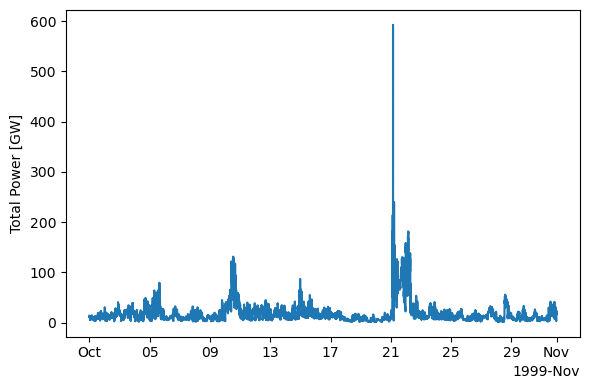

In [43]:
fig, ax = plt.subplots(figsize=(6,4))
ds_E['total_power'].plot(ax=ax)
plt.ylabel('Total Power [GW]')
plt.xlabel(' ')
plt.tight_layout()
#plt.savefig('ESN_Total_Power.png', dpi=300)

/tmp/ipykernel_59075/3453015841.py:7: UserWarning: The following kwargs were not used by contour: 'center'
  contour = axs.contourf(theta_rad, r, Ex, cmap='bwr', levels=100, extend='both', center=0)


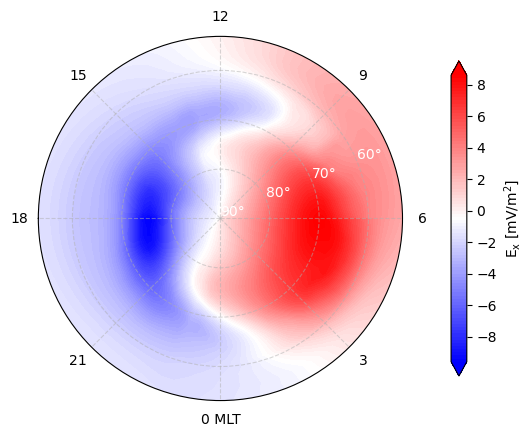

In [44]:
theta = np.linspace(0, 360, 79)
theta_rad = np.deg2rad(theta)
r = 90 - np.linspace(53.1, 90, 29)
fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(5.5, 4.5))

Ex = ds_E['Ex'].mean(dim='dt').values / 1e-3
contour = axs.contourf(theta_rad, r, Ex, cmap='bwr', levels=100, extend='both', center=0)
Qj_label = r'E$_\mathrm{x}$ [mV/m$^2$]'
plt.colorbar(contour, ax=axs, label=f'{Qj_label}',pad=0.1,shrink=0.8)
#axs.set_ylim([0, 50])
axs.set_yticks([0, 10, 20, 30])
axs.set_yticklabels(["90°", "80°", "70°", "60°"], color='white')
axs.set_xlim([-np.pi, np.pi])
axs.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs.set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
#plt.savefig('electric_field_avg.png', dpi=300)

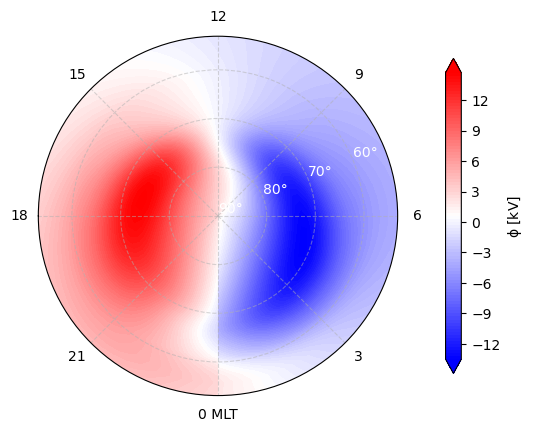

In [45]:
theta = np.linspace(0, 360, 79) -90
theta_rad = np.deg2rad(theta)
r = 90 - np.linspace(53.1, 90, 29)
fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(5.5, 4.5))


Ex = ds_E['esn_pot'].mean(dim='dt').values
contour = axs.contourf(theta_rad, r, Ex, cmap='bwr', levels=100, extend='both')
Qj_label = r'$\mathrm{\phi}$ [kV]'
plt.colorbar(contour, ax=axs, label=f'{Qj_label}',pad=0.1,shrink=0.8)
#axs.set_ylim([0, 50])
axs.set_yticks([0, 10, 20, 30])
axs.set_yticklabels(["90°", "80°", "70°", "60°"], color='white')
axs.set_xlim([-np.pi, np.pi])
axs.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs.set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

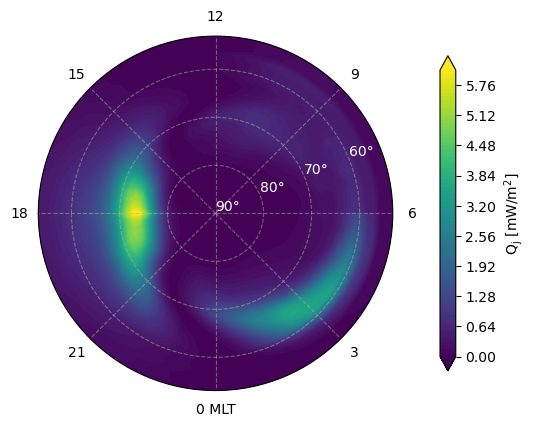

In [47]:
theta = np.linspace(0, 360, 79)
theta_rad = np.deg2rad(theta)
r = 90 - np.linspace(53.1, 90, 29)
fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(5.5, 4.5))

Ex = ds_E['Qjx'].sel(dt='1999-10-22 05:00:00').values
#Ex = ds_E['Qjx'].mean(dim='dt').values
contour = axs.contourf(theta_rad, r, Ex, cmap='viridis', levels=100, extend='both')
Qj_label = r'Q$_\mathrm{j}$ [mW/m$^2$]'
plt.colorbar(contour, ax=axs, label=f'{Qj_label}',pad=0.1,shrink=0.8)
#axs.set_ylim([0, 50])
axs.set_yticks([0, 10, 20, 30])
axs.set_yticklabels(["90°", "80°", "70°", "60°"], color='white')
axs.set_xlim([-np.pi, np.pi])
axs.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs.set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
#plt.savefig('joule_heating_avg.png', dpi=300)